In [1]:
from IPython import display
import matplotlib
import matplotlib.pyplot as plt
import cv2
import numpy as np
%matplotlib inline

In [2]:
import gym

from stable_baselines.common.policies import MlpPolicy
from stable_baselines.common.policies import CnnPolicy
from stable_baselines.common.vec_env import DummyVecEnv
from stable_baselines.common.cmd_util import make_atari_env
from stable_baselines.common.vec_env import VecFrameStack
from a2c_vis import A2C

import a2c_main_vis as a2c


env = make_atari_env('PongNoFrameskip-v4', num_env=1, seed=33, wrapper_kwargs={"episode_life": False, "clip_rewards": False}) 
env = VecFrameStack(env, n_stack=4)

model = A2C.load("A2CVIS_ARNSRF_Pong_log_20200227/model_training/model_120000.zip")


Loading a model without an environment, this model cannot be trained until it has a valid environment.
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead


KeyboardInterrupt: 

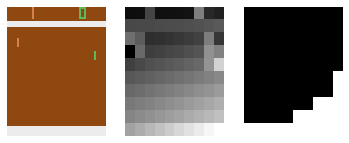

In [55]:
obs = env.reset()

# plt.imshow(env.render(mode='rgb_array'))

img = plt.imshow(env.render(mode='rgb_array'))

done = False
reward_sum = 0
reward_list = [reward_sum]
while not done:
    
    plt.subplot(1, 3, 1)
    plt.axis('off')
    plt.imshow(env.render(mode='rgb_array'))
    img.set_data(env.render(mode='rgb_array')) # just update the data
    display.display(plt.gcf())
    display.clear_output(wait=True)
    
    action, _states, att, relations = model.predict(obs, deterministic=False)
    
#     print(att.shape)
#     print(relations.shape)
    
    att = np.squeeze(att)
    att_sum = np.sum(att, axis=0)
    att_sum = np.reshape(att_sum, newshape=[10, 10])
    att_resized = cv2.resize(att_sum, (160,210), interpolation=cv2.INTER_NEAREST)
    
    ix = np.unravel_index(att.argsort(axis=None), dims=att.shape)
    
    k = 50
    top_k_pos = list(zip(*np.unravel_index(att.argsort(axis=None), dims=att.shape)))[::-1][:k]
    
#     print(top_k_pos)
    
    important_relations = np.zeros((10, 10, 3))
    
    for max_pos in top_k_pos:
        max_source = (int(max_pos[0]/10), max_pos[0]%10)
        max_target = (int(max_pos[1]/10), max_pos[1]%10)
    
        important_relations[max_source[0],max_source[1], :] = 1
        important_relations[max_target[0],max_target[1], :] = 1
    
    
    max_pos = np.unravel_index(np.argmax(att),att.shape)
    max_source = (int(max_pos[0]/10), max_pos[0]%10)
    max_target = (int(max_pos[1]/10), max_pos[1]%10)
    
#     important_relations = np.zeros((10, 10, 3))
    important_relations[max_source[0],max_source[1], :] = 1
    important_relations[max_target[0],max_target[1], :] = 1
#     important_relations[0,1, :] = 1
    important_relations_resized = cv2.resize(important_relations, (160, 210), interpolation=cv2.INTER_NEAREST)
    
    plt.subplot(1, 3, 2)
    plt.axis('off')
    plt.imshow(att_resized, cmap='gray')
    
    plt.subplot(1, 3, 3)
    plt.axis('off')
    plt.imshow(important_relations_resized)
    
#     plt.plot([6, 22], [10.5, 105+10.5], color='w')
    
    for max_pos in top_k_pos:
        max_source = (int(max_pos[0]/10), max_pos[0]%10)
        max_target = (int(max_pos[1]/10), max_pos[1]%10)
        plt.plot([(max_pos[0]%10)*16+8,(max_pos[1]%10)*16+8], [int(max_pos[0]/10)*21+10.5, int(max_pos[1]/10)*21+10.5], color='w')
        
    plt.show()
    
    obs, rewards, done, info = env.step(action)
    reward_sum += rewards[0]
    if rewards[0] != 0:
#         print(reward_sum)
        reward_list.append(reward_sum)
    
    
#     print(att)
#     print(max_pos)
#     print(np.argmax(att))
    
print(reward_sum)
print(reward_list)
env.close()
